## Plan
- create model
    - male or female
    - CH, AD, EL
- extract additive infomation
    - length
    - sceptrum infomation

In [1]:
import os 
import numpy as np
import pandas as pd
import librosa
import pyworld
import time
import shutil
import matplotlib.pyplot as plt

from tools import *
from model import *

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [2]:
seed_value = 0
np.random.seed(seed_value)
torch.manual_seed(seed_value)

In [3]:
data_dir = "../data/NTT_corevo"

In [4]:
class_train = pd.read_csv(os.path.join(data_dir, "class_train.tsv"), delimiter='\t', header=None)
sample_submit = pd.read_csv(os.path.join(data_dir, "class_train.tsv"), delimiter='\t', header=None)

In [5]:
class_train.head()

,0,1
0,0002f1cd968ca78ada9e1c7037224773,MA_CH
1,0003747ec9268461d4cbb9e1b86e9663,FE_AD
2,0003b32f378b001f0f73bf0981da8773,MA_CH
3,0004ab975bf8b59e1b19f2b7b6d1548b,MA_CH
4,0005678b57ca265a65f8ef0cc7481277,MA_AD


In [6]:
sample_submit.tail()

,0,1
37801,fff371f8fd363481780cf71abadd3912,FE_EL
37802,fffad7d70023ac8019976bfc7d9ba36d,MA_EL
37803,fffb68964f56e10022d62feba2e538d3,FE_AD
37804,fffdd34e46338d68f3eb7081b2c7f069,FE_AD
37805,ffff83dd1058ef7fd97151be4d61651f,MA_AD


In [7]:
class_train[class_train[0] == "fff371f8fd363481780cf71abadd3912"]

,0,1
37801,fff371f8fd363481780cf71abadd3912,FE_EL


In [8]:
train_data_dir = os.path.join(data_dir, "train")
files = os.listdir(train_data_dir)

if (False):
    if not os.path.exists(os.path.join(data_dir, "labeled/00/")):
        os.makedirs(os.path.join(data_dir, "labeled/00/"))
    if not os.path.exists(os.path.join(data_dir, "labeled/01/")):
        os.makedirs(os.path.join(data_dir, "labeled/01/"))
    if not os.path.exists(os.path.join(data_dir, "labeled/02/")):
        os.makedirs(os.path.join(data_dir, "labeled/02/"))
    if not os.path.exists(os.path.join(data_dir, "labeled/03/")):
        os.makedirs(os.path.join(data_dir, "labeled/03/"))
    if not os.path.exists(os.path.join(data_dir, "labeled/04/")):
        os.makedirs(os.path.join(data_dir, "labeled/04/"))
    if not os.path.exists(os.path.join(data_dir, "labeled/05/")):
        os.makedirs(os.path.join(data_dir, "labeled/05/"))
    for file in files:
        file_id = file[:-4]
        label = class_train[class_train[0] == file_id].values[0,1]
        if (label == "FE_CH"):
            shutil.copy(os.path.join(train_data_dir, file), os.path.join(data_dir, "labeled/00/" + file))
        elif (label == "FE_AD"):
            shutil.copy(os.path.join(train_data_dir, file), os.path.join(data_dir, "labeled/01/" + file))
        elif (label == "FE_EL"):
            shutil.copy(os.path.join(train_data_dir, file), os.path.join(data_dir, "labeled/02/" + file))
        elif (label == "MA_CH"):
            shutil.copy(os.path.join(train_data_dir, file), os.path.join(data_dir, "labeled/03/" + file))
        elif (label == "MA_AD"):
            shutil.copy(os.path.join(train_data_dir, file), os.path.join(data_dir, "labeled/04/" + file))
        elif (label == "MA_EL"):
            shutil.copy(os.path.join(train_data_dir, file), os.path.join(data_dir, "labeled/05/" + file))

label_num = np.zeros((6,))
for i in range(6):
    label_num[i] = len(os.listdir(os.path.join(data_dir, "labeled/0" + str(i))))

## Labels
- 0: female child
- 1: female adult
- 2: female elder
- 3: male child
- 4: male adult
- 5: male elder

/home/takiguchi/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


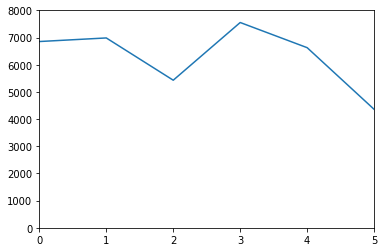

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(label_num)
ax.set_xlim(0,5)
ax.set_ylim(0, 8000)
fig.show()

In [10]:
sampling_rate = 16000
num_mcep = 36
frame_period = 5.0
n_frames = 1024
label_num = 6

In [11]:
def data_load(batch_size = 1, label = -1):
    data_list = []
    label_list = []
    
    if (label == -1):
        random_label = True 
    else:
        random_label =  False
        
    for i in range(batch_size):
        
        if random_label :
            label = np.random.randint(0, label_num)
            
        sample_data_dir = os.path.join(data_dir, "labeled/{:02}".format(label))
        file = np.random.choice(os.listdir(sample_data_dir))
        
        frames = 0
        count = 0
        while frames < n_frames:

            wav, _ = librosa.load(os.path.join(sample_data_dir, file), sr = sampling_rate, mono = True)
            wav = librosa.util.normalize(wav, norm=np.inf, axis=None)
            wav = wav_padding(wav = wav, sr = sampling_rate, frame_period = frame_period, multiple = 4)
            f0, timeaxis, sp, ap, mc = world_decompose(wav = wav, fs = sampling_rate, frame_period = frame_period, num_mcep = num_mcep)

            if (count == 0):
                mc_transposed = np.array(mc).T
            else:
                mc_transposed = np.concatenate([mc_transposed, np.array(mc).T], axis =1)
            frames = np.shape(mc_transposed)[1]

            mean = np.mean(mc_transposed)
            std = np.std(mc_transposed)
            mc_norm = (mc_transposed - mean)/std

            print(frames)
            
            count += 1

        start_ = np.random.randint(frames - n_frames + 1)
        end_ = start_ + n_frames

        data_list.append(mc_norm[:,start_:end_])
        label_list.append(label)

    return torch.Tensor(data_list).view(batch_size, 1, num_mcep, n_frames), torch.Tensor(label_list).view(batch_size, 1)


In [12]:
a, b = data_load(batch_size=4, label=-1)

288
576
864
1152
960
1920
512
1024
512
1024


In [13]:
print(a.shape)
print(b.shape)
print(b)

torch.Size([4, 1, 36, 1024])
torch.Size([4, 1])
tensor([[4.],
        [0.],
        [3.],
        [1.]])


In [14]:
model_dir_vae = "../model/NTT_corevo/VAE"
model_name_vae = "VAE_lr3_e10000_b4"

def model_load_VAE(model_dir, model_name):
    model = VAE()
    model.load_state_dict(torch.load(os.path.join(model_dir, model_name)))
    return model
    
model_dir_classifier = "../model/NTT_corevo/Classifier"
model_name_classifier = [
    "Classifier_lr3_e10000_b4_label0",
    "Classifier_lr3_e10000_b4_label1",
    "Classifier_lr3_e10000_b4_label2",
    "Classifier_lr3_e10000_b4_label3",
    "Classifier_lr3_e10000_b4_label4",
    "Classifier_lr3_e10000_b4_label5"
]

def model_load(label):
    model = Classifier()
    model.load_state_dict(torch.load(os.path.join(model_dir_classifier, model_name_classifier[label])))
    return model